In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
## IMPORTS 
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import random 
import torch
import torchvision 
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T

#import torchvision
#from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 


import splitfolders
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import glob
import time
import PIL
from PIL import Image
import os

In [4]:
#LOADING DATA 

# Original images 
full_data_path= '/content/drive/MyDrive/medium_structure_model/images_128_patches_small'
output_images='/content/drive/MyDrive/medium_structure_model/images_128_patches_small_split'



#Associated depth maps
full_depth_maps_path = '/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small'
output_depth_maps='/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small_split'

In [5]:
## DATA PATH WITH ALL THE PATCHES  (comment when working with the small network)
#full_data_path= '/content/drive/MyDrive/medium_structure_model/images_128_small'
#output_images='/content/drive/MyDrive/medium_structure_model/images_128_patches_split'

#full_depth_maps_path = '/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches'
#output_depth_maps='/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_split'

In [6]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [7]:
# Activate cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [8]:
#Splitting the data into train, test, val (small files)

#splitfolders.ratio(full_data_path, output=output_images, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values
#splitfolders.ratio(full_depth_maps_path, output=output_depth_maps, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)
#step done, uncomment if you need to split other files 

In [9]:
#Final paths:

train_images_path='/content/drive/MyDrive/medium_structure_model/images_128_patches_small_split/train/class0'
test_images_path='/content/drive/MyDrive/medium_structure_model/images_128_patches_small_split/test/class0'
val_images_path='/content/drive/MyDrive/medium_structure_model/images_128_patches_small_split/val/class0'


train_depth_maps_path='/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small_split/train/class0'
test_depth_maps_path='/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small_split/test/class0'
val_depth_maps_path='/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small_split/val/class0'




In [10]:
# GLOBAL VARIABLES

image_size=128  

In [11]:
#LOADING DATA

def load_data(data_path, verbose=False):
    DATA_LOADED=False 
    print_every_n_loads=10
    images=[]
    ind=0
    t0=time.time()
    if not DATA_LOADED:
        print('Loading data...')
    for filename in os.listdir(data_path):
        img = mpimg.imread(os.path.join(data_path, filename))
        if img is not None:
            images.append(np.asarray(img))
            ind+=1
        if verbose:
            if ind%print_every_n_loads==0:
                print('nb of data loaded:', ind)
    print(f'Loaded data in: {time.time()-t0 } s')
    return images

train_images=load_data(train_images_path)
val_images=load_data(val_images_path)
test_images=load_data(test_images_path)

train_depth_maps=load_data(train_depth_maps_path)
val_depth_maps=load_data(val_depth_maps_path)
test_depth_maps=load_data(test_depth_maps_path)

Loading data...
Loaded data in: 2.4434804916381836 s
Loading data...
Loaded data in: 0.23813533782958984 s
Loading data...
Loaded data in: 0.2520866394042969 s
Loading data...
Loaded data in: 1.4480392932891846 s
Loading data...
Loaded data in: 0.1665360927581787 s
Loading data...
Loaded data in: 0.19618535041809082 s


In [12]:
DATA_LOADED=True
NUM_TRAIN=len(train_images)
NUM_VAL=len(val_images)
NUM_TEST=len(test_images)

Image dimensions : 128*128
data type : float32


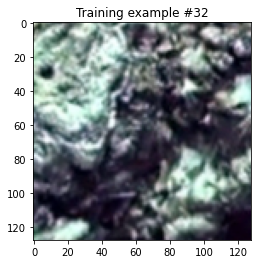

In [13]:
# Some information about the dataset
data_type = train_images[0][0].dtype
H, W, C=train_images[0].shape
#print("Training dataset length :", NUM_TRAIN)
#print("Validation dataset length :", NUM_VAL)
print(f"Image dimensions : {H}*{W}")
print("data type :", data_type)
plt.imshow(train_images[32])
plt.title(f"Training example #{32}")
plt.show()


In [14]:
print(np.shape(train_images))

(721, 128, 128, 3)


In [15]:
def get_mean_std(fulldata):
      eps=1e-5
      mean=np.mean(np.mean(np.mean(fulldata, axis=1), axis=1), axis=0)
      std=np.std(np.std(np.std(fulldata, axis=1), axis=1), axis=0)+eps
      return mean, std

In [16]:
from matplotlib.colors import Normalize
## CREATING A CUSTOM DATASET STRUCTURE WHERE THE DEPTH MAP IS THE LABEL

# https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec: interesting website

class Original_and_Depth_Map(torch.utils.data.Dataset):

    def __init__(self, datasetA, datasetB, transform=False):
        self.datasetA = np.array(datasetA).astype(np.uint8)
        self.datasetB = np.array(datasetB).astype(np.uint8)
        self.meanA, self.stdA=get_mean_std(datasetA)
        self.meanB, self.stdB=get_mean_std(datasetB)
        self.transformA = T.Compose([T.ToTensor()
       , T.Normalize(self.meanA, self.stdA)
        ])
        self.transformB = T.Compose([  T.ToTensor(), T.Normalize(self.meanB, self.stdB),
       ])
    

        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        tA=self.transformA(xA)
        tB=self.transformB(xB)
        return tA, tB

    def __len__(self):
        return len(self.datasetA)



In [17]:
batch_size = 32

train_dataset =Original_and_Depth_Map(train_images, train_depth_maps)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

val_dataset =Original_and_Depth_Map(val_images, val_depth_maps)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

test_dataset =Original_and_Depth_Map(test_images, test_depth_maps)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [18]:
for i in range (len(train_dataset)):
  sample=train_dataset[i]
  print(i, sample[0].size(), sample[1].size())
  if i==3:
    break

0 torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
1 torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
2 torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
3 torch.Size([3, 128, 128]) torch.Size([1, 128, 128])


In [19]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images[0], nmax)
        break

In [20]:
## Using different metrics to evaluate performances of the network

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

#A loss robust to outliers + large data values 

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(np.abs(pred + 1)), torch.log(np.abs(actual + 10))))

In [21]:
### DESIGNING THE MODEL 

class Simple_Autoencoder(nn.Module):
  def __init__(self):
        super(Simple_Autoencoder, self).__init__()
        
        
        self.encoder = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=2, stride=2, padding=0), nn.ReLU(), nn.BatchNorm2d(64),
        nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0), nn.ReLU(), nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, kernel_size=2, stride=2), nn.ReLU(), nn.BatchNorm2d(256)
        )
        
        #nn.Conv2d(256, 512, kernel_size=2, stride=2), nn.ReLU()
        #nn.ConvTranspose2d(512, 256, 2, stride=2), nn.ReLU(),
        
        #WITH CONVTRANSPOSE 2D
        """self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256,128, 2, stride=2), nn.LeakyReLU(), nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128, 64, 2, stride=2), nn.LeakyReLU(), nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, 2, stride=2)
        )"""

        #WITH UPSAMPLING, AND CONVOLUTIONS
        self.decoder = nn.Sequential(
        nn.Upsample(scale_factor=2), nn.Conv2d(256,128, 3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(128),
        nn.Upsample(scale_factor=2), nn.Conv2d(128, 64, 3, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(64),
        nn.Upsample(scale_factor=2), nn.ConvTranspose2d(64, 1, 3, padding=1)
        )

  def forward(self, x):
      z=self.encoder(x)
      return self.decoder(z)
  

In [22]:
#Checking output size

from torchsummary import summary

ae=Simple_Autoencoder()
input=torch.zeros((3,128,128))
summary(ae, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             832
              ReLU-2           [-1, 64, 64, 64]               0
       BatchNorm2d-3           [-1, 64, 64, 64]             128
            Conv2d-4          [-1, 128, 32, 32]          32,896
              ReLU-5          [-1, 128, 32, 32]               0
       BatchNorm2d-6          [-1, 128, 32, 32]             256
            Conv2d-7          [-1, 256, 16, 16]         131,328
              ReLU-8          [-1, 256, 16, 16]               0
       BatchNorm2d-9          [-1, 256, 16, 16]             512
         Upsample-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         295,040
        LeakyReLU-12          [-1, 128, 32, 32]               0
      BatchNorm2d-13          [-1, 128, 32, 32]             256
         Upsample-14          [-1, 128,

In [23]:
# Defining the model and the parameters

autoencoder=Simple_Autoencoder()

# Choose learning rate
lr = 1e-3

# Choose optimizer
optim = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-3) 

In [24]:
# Checking input sizes by hand 

input=torch.zeros((3,128,128))
print("Input size:", input.size())


print('\n #----Encoder Part-----')
output= nn.Conv2d(3, 64, kernel_size=2, stride=2, padding=0)(input)
output= nn.BatchNorm1d(64)(output)

print( 'first output size: ', output.size())
output1=nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0)(output)

output1= nn.BatchNorm1d(32)(output1)
print( 'second output size: ', output1.size())

output2=nn.Conv2d(128, 256, kernel_size=2, stride=2)(output1)
output2= nn.BatchNorm1d(16)(output2)
print( 'third output size: ', output2.size())

print(' \n# ----Decoder Part-----')

output3=nn.ConvTranspose2d(256,128, 2, stride=2)(output2)
print(" ConvTranspose2d size:", output3.size())
output4=nn.ConvTranspose2d(128, 64, 2, stride=2)(output3)
print(" ConvTranspose2d size:", output4.size())
output5= nn.ConvTranspose2d(64, 1, 2, stride=2)(output4)
print(" 2nd ConvTranspose2d size:", output5.size())



Input size: torch.Size([3, 128, 128])

 #----Encoder Part-----
first output size:  torch.Size([64, 64, 64])
second output size:  torch.Size([128, 32, 32])
third output size:  torch.Size([256, 16, 16])
 
# ----Decoder Part-----
 ConvTranspose2d size: torch.Size([128, 32, 32])
 ConvTranspose2d size: torch.Size([64, 64, 64])
 2nd ConvTranspose2d size: torch.Size([1, 128, 128])


In [25]:
#Checking size compatibility
d_test=autoencoder.forward(torch.zeros((1,3,128,128)))
print(d_test.size())
#It works !

torch.Size([1, 1, 128, 128])


In [26]:
## Training function

## Training function
def train_epoch(network, device, dataloader, optimizer, loss_function, print_every = 1):
    """ Trains the simple model for one epoch. losses_resolution indicates how often training_loss should be printed and stored. """
    network.train()
    train_losses = []
    # Iterate the dataloader (We do not need the label value which is 0 here, the depth maps are the labels)
    iter = 0
    for image, depth_map in dataloader:  # shape=(el, label) --> image= (el, 0)  depth_map=(el, 0)  d= [image, depth_map]
        #print(voltage)
        im = image[0].to(device)
        im=np.reshape(im, [1,3,128,128])
        #print("im shape:", im.shape)
        d= depth_map[0].to(device)
        #print("d shape:", d.shape)
        
        iter += 1
        d_hat = network(im)

        
        #print("d_hat shape:", d_hat.shape)
        # Evaluate loss
        loss = loss_function(d_hat, d)

        # Backward pass
        optimizer.zero_grad()  # Sets the gradients attached to the parameters objects to zero.
        loss.backward()  # Uses the gradient object attached to the loss to recursively compute the gradients of the parameters of the network (and store their value in the gradient objects attached to said parameters)
        optimizer.step()  # Actually chages the values of the parameters using their gradients, computed on the previous line of code.
        
        # Print and store batch loss
        batch_loss = loss.item()/d.shape[0]
        train_losses.append(batch_loss)
        
        #Display
        #if iter%print_every == 0:
            #print(f'\t partial train loss (single batch): {batch_loss:.2f}')
    return train_losses


In [27]:
### Testing function

def validation_epoch(network, device, loss_function, dataloader):
    "Set evaluation mode for encoder and decoder"

    network.eval()  # evaluation mode, equivalent to "network.train(False)""
    val_loss = 0
    with torch.no_grad(): # No need to track the gradients
        for image, depth_map in dataloader:
            im = (image[0].to(device))
            d = depth_map[0].to(device)
            # Move tensor to the proper device
            # h = h.to(device)
            #print('im shape:', im.size())
            #print('d shape:', d.size())
            im=np.reshape(im, [1,3,128,128])
            d_hat = network(im)
            loss = loss_function(d_hat, d)
            val_loss += loss.item()/d.shape[0]

    return val_loss/len(dataloader)

In [28]:
#Plotting the learning and validation loss curves


def plot_learning_curves(train_losses, val_losses):
    """ Plots the learning curve. Losses resolution (how many times the loss is displayed) is one value per batch for the training losses, and one value per epoch for the validation. """
    iterations_train = np.arange(0, batch_size*train_losses.size, batch_size)
    iterations_validation = np.arange(0, NUM_TRAIN*val_losses.size, NUM_TRAIN)

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.plot(iterations_train, train_losses, color="blue", label="training loss")
    ax.plot(iterations_validation, val_losses/100, color="orange", label = "validation loss")
    ax.set(xlabel="iterations", ylabel="loss", title="Training and validation losses over iterations")
    ax.grid()
    ax.legend()

    fig.show()

In [29]:
print(test_dataset[0][0].size())

torch.Size([3, 128, 128])


In [30]:
#Testing the trained network on test data

def plot_ae_outputs(ae, number_outputs=5, random_plots=True, indices=None):
  """
    When random_plots = True, different images are taken between each epoch.
    When random_plots = False, indices indicates what images to plot
  """
  fig = plt.figure(figsize=(5*number_outputs,8.5))
  
  #Selection of random images to plot within the dataset or a select set of indices
  if random_plots:
      plotted_samples = np.random.choice(NUM_TEST, number_outputs)
  else:
      plotted_samples = indices
  
  for i in range(number_outputs):
      ax = plt.subplot(2, number_outputs, i+1)
      # plt.subplot(nb_rows, nb_cols, num)  where num is indexed from 1
      img = test_dataset[plotted_samples[i]][0].unsqueeze(0) # unsqueeze so that the image can be interpreted as a single-sampled batch, to fit in the ae
      ae.eval()
      
      with torch.no_grad():
        output_img  = ae(img)
     
      
      plt.imshow((np.transpose(img.cpu().squeeze().numpy())*255).astype(np.uint8))
      plt.colorbar()
      ax.set_xlabel(f"prof$_{{max}}={img.max():.2f}$")
      
      if i == number_outputs//2:
          ax.set_title('Original depth maps')
      ax = plt.subplot(2, number_outputs, i + 1 + number_outputs)
      plt.imshow((np.transpose(output_img.cpu().squeeze().numpy())*255).astype(np.uint8))
      plt.colorbar()
      ax.set_xlabel(f"$prof_{{max}}={output_img.max():.2f} m $")
      
      
      if i == number_outputs//2:
          ax.set_title('Reconstructed depth maps')
  return fig



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



 EPOCH 1/20 	 train loss 0.474 	 val loss 61.677

 EPOCH 2/20 	 train loss 0.394 	 val loss 195.559

 EPOCH 3/20 	 train loss 0.175 	 val loss 201.892

 EPOCH 4/20 	 train loss 0.244 	 val loss 624.714

 EPOCH 5/20 	 train loss 0.281 	 val loss 565.163

 EPOCH 6/20 	 train loss 0.174 	 val loss 338.833

 EPOCH 7/20 	 train loss 0.148 	 val loss 1170.883

 EPOCH 8/20 	 train loss 0.135 	 val loss 540.530

 EPOCH 9/20 	 train loss 0.281 	 val loss 170.108

 EPOCH 10/20 	 train loss 0.249 	 val loss 412.106

 EPOCH 11/20 	 train loss 0.241 	 val loss 220.859

 EPOCH 12/20 	 train loss 0.324 	 val loss 170.891

 EPOCH 13/20 	 train loss 0.268 	 val loss 372.866

 EPOCH 14/20 	 train loss 0.181 	 val loss 150.015

 EPOCH 15/20 	 train loss 0.185 	 val loss 273.820

 EPOCH 16/20 	 train loss 0.118 	 val loss 1768.853

 EPOCH 17/20 	 train loss 0.263 	 val loss 553.310

 EPOCH 18/20 	 train loss 0.185 	 val loss 162.081

 EPOCH 19/20 	 train loss 0.415 	 val loss 107.355

 EPOCH 20/20 	 trai

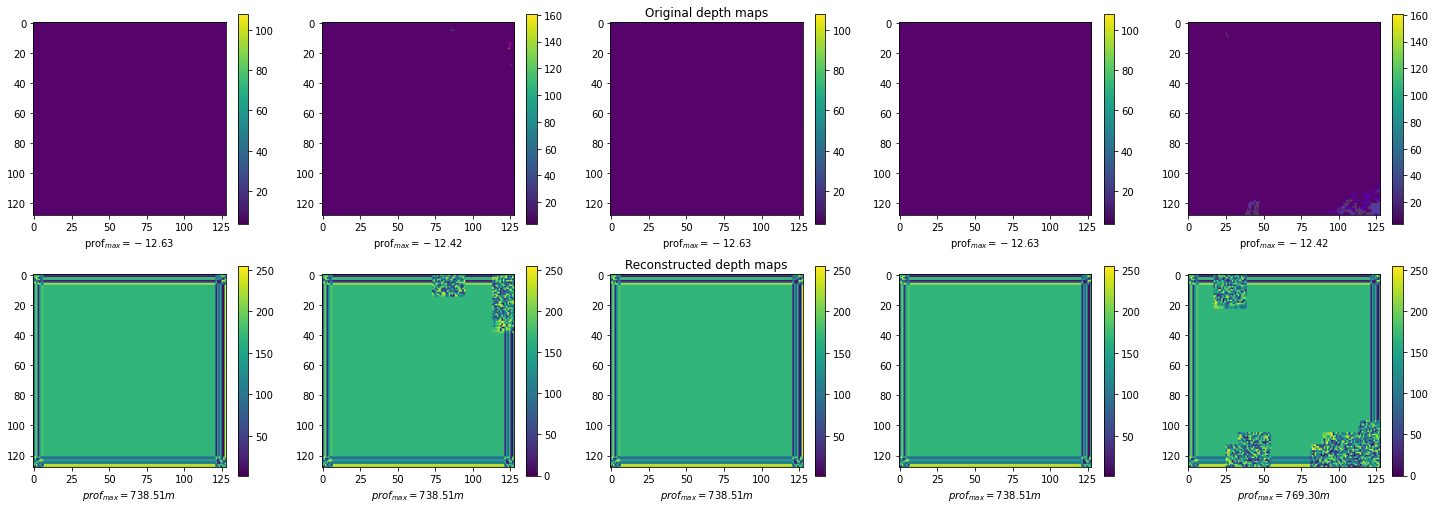

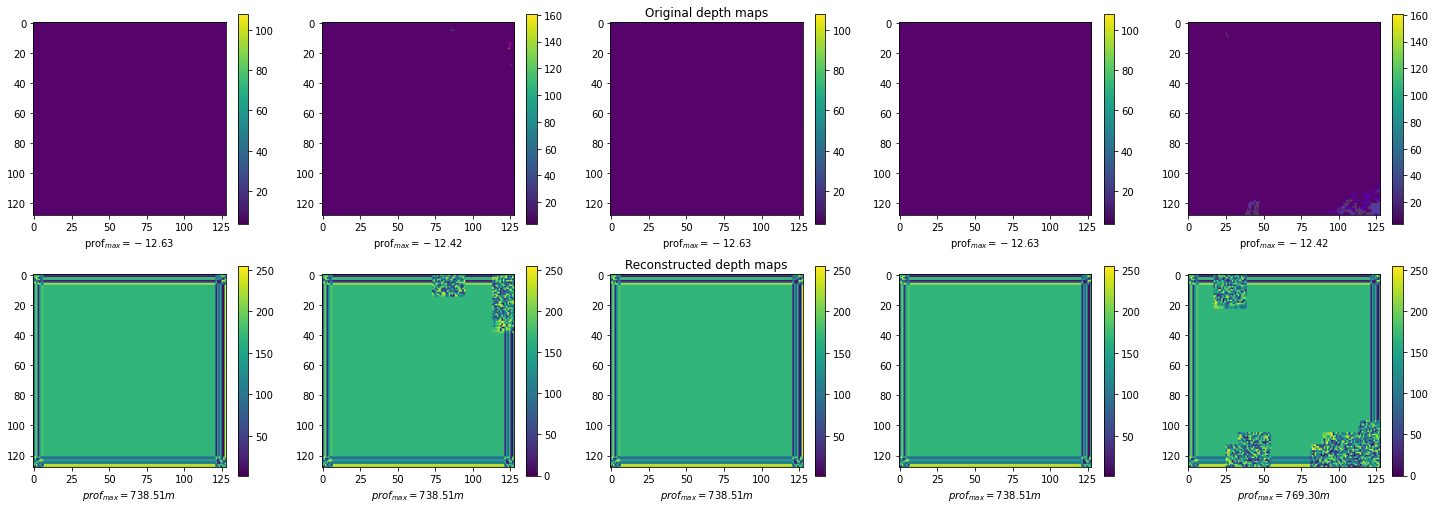

In [31]:
## Training and Validation processes

number_of_plotted_images = 5
plot_images_every_n_epochs = 2
random_plots = True
indices_to_plot = np.arange(number_of_plotted_images)
num_epochs= 20

## Choice of the loss
mse=nn.MSELoss()
rmse=RMSELoss()
rmsle=RMSLELoss()


train_losses = np.array([])
val_losses = np.array([validation_epoch(autoencoder, device, rmsle, val_loader)])


## Training process

for epoch in range(num_epochs):
   train_losses_epoch = train_epoch(autoencoder, device, train_loader,optim, rmse)
   val_loss_epoch = validation_epoch( autoencoder, device, rmse, val_loader)
   train_losses = np.concatenate((train_losses, train_losses_epoch))
   val_losses = np.append(val_losses, val_loss_epoch)
   print(f'\n EPOCH {epoch + 1}/{num_epochs} \t train loss {train_losses_epoch[-1]:.3f} \t val loss {val_loss_epoch:.3f}')



#Plotting 5 images at the end of the reconstruction
# To see the evolution of the reconstruction, integrate in the for loop.

plot_ae_outputs(autoencoder, number_outputs=number_of_plotted_images, random_plots=random_plots, indices=indices_to_plot)

The prof max parameter does not mean anything, I have to take it off. Yet we see that some small patterns are recognisable after training.

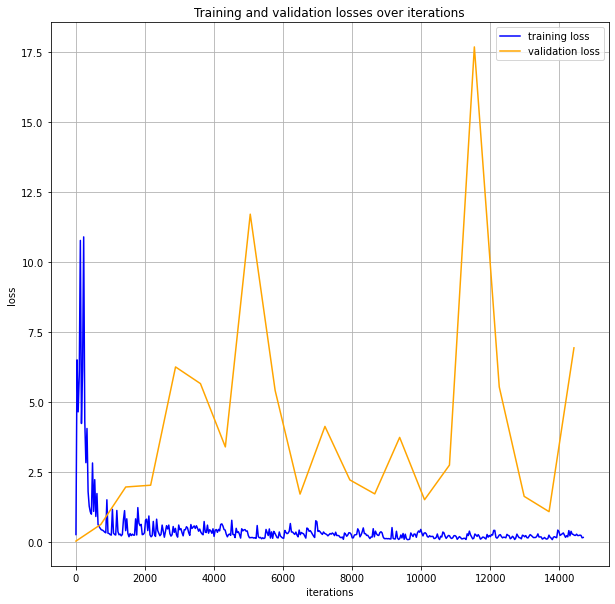

In [32]:
plot_learning_curves(train_losses, val_losses)

The validation is horribly high compared to the training loss (I divided it by 100 in the plot). This shows that the model overfits, which is coherent as the model as around 20 000 parameters and I only put 900 images in input. 